# Image search using SIFT

Let's think about information retrieval in the context of image search. How can we find images similar to a query in a fast way (faster than doing pair-wise comparison with all images in a database)? How can we identify same objects taken in slightly different contexts? 

One way to do this is to find special points of interest in every image, so called keypoints (or descriptors), which characterize the image and which are more or less invariant to scaling, orientation, illumination changes, and some other distortions. There are several algorithms available that identify such keypoints, and today we will focus on [SIFT](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). 

Your task is to apply SIFT to a dataset of images and enable similar images search.

## Data

We will use Caltech 101 dataset, download it from [here](http://www.vision.caltech.edu/Image_Datasets/Caltech101/). It consists of pictures of objects belonging to 101 categories. About 40 to 800 images per category. Most categories have about 50 images. The size of each image is roughly 300 x 200 pixels.

In [0]:
from IPython.display import clear_output

!wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
!tar xvzf /content/101_ObjectCategories.tar.gz

clear_output()

## SIFT example

Below is an example how to extract SIFT keyponts using `opencv`. [This](https://docs.opencv.org/trunk/da/df5/tutorial_py_sift_intro.html) is a dedicated tutorial, and [this](https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html) is another tutorial you may need to find matches between two images.

In [0]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16
clear_output()

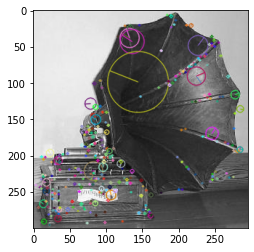

In [3]:
import cv2 as cv
from matplotlib import pyplot as plt

img_dir = '101_ObjectCategories'
img = cv.imread(img_dir + '/gramophone/image_0018.jpg')
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)
img=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)

## Task 1. Index keypoints

Let's suppose we've found image descriptors. How do we find similar images, having this information? In our case the descriptors are 128-dinensional vectors per keypoint, and there can be hundreds of such points. To enable fast search of similar images, we will index descriptors of all images using some datastructure for approximate nearest neighbors search, such as Navigable Small World or Annoy. Then, for a query image we generate its descriptors, and for each of them find its k nearest neighbors (using Euclidean or Cosine distance). Finally, we sort potential similar images (retrieved from neighbor descriptors) by frequency with which they appear in k nearest neighbors.



Read all images, saving category information. For every image generate SIFT descriptors and index them using some datastructure for inexact nearest neighbors search, e.g., I am using HNSW from [`nmslib`](https://github.com/nmslib/nmslib).

# I'm sorry for not really clean code

In [0]:
# !pip install --user annoy

In [5]:
# TODO: read all images, generate its descriptors and index them
# You may face computational problems due to large number of descriptors.
# To mitigate it, pick only top_k descriptors for each image, sorted by 
# "response" attribute of a KeyPoint object, which reflects the "goodness" of a point

# print(f'key point {kp[1].response}')
import os
from annoy import AnnoyIndex

def load_one(img_path, top_k = 50):
  img = cv.imread(img_path)
  gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
  sift = cv.xfeatures2d.SIFT_create(top_k)
  # kp, des = sift.detectAndCompute(gray,None) # this is a list of key points
  # kp = sift.detect(gray,None)
  # sorted_kp = sorted(kp, key = lambda x: x.response, reverse = True)[:top_k]
  kp, des = sift.detectAndCompute(gray, None) # this is a list of key points
  return des
  
def load_images(data_dir = '101_ObjectCategories'):
  key_points = []
  keypoint_ids = []
  imgpath_label = {}
  keypointid_imagepath = {}
  categories = {cat:i for i, cat in enumerate(os.listdir(data_dir)) }

  for cat, idx in categories.items():
    cat_path = os.path.join(data_dir, cat)
    list_of_images = os.listdir(cat_path)
    for img_name in list_of_images:
      img_path = os.path.join(cat_path, img_name)
      kps = load_one(img_path)
      try:
        for kp in kps:
          key_points.append(kp)
          k_id = len(keypoint_ids)
          keypoint_ids.append(k_id)
          keypointid_imagepath[k_id] = img_path
          imgpath_label[img_path] = idx
      except:
        continue
  return key_points, keypoint_ids, imgpath_label, keypointid_imagepath, categories, len(categories)

# LOAD DATA 
key_points, keypoint_ids, imgpath_label, keypointid_imagepath, categories, n_cat = load_images()
print('Data load completed, creating index ...')

Data load completed, creating index ...


In [6]:
!pip install nmslib

In [0]:
import nmslib
import numpy as np

key_points_array = np.array(key_points)

index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(key_points_array)
index.createIndex()

## Task 2. Find similar and evaluate

Now, having index calculated, let's pick **one image from each category** (**the first one**, for sync), and find its **10** most similar images among all images. When submitting, please **only include the output of similar images for the "accordion" category**, as demonstrated below, so that the notebook doesn't grow too big.

If a similar image belongs to the same category, we consider it as a hit. At last, compute and print the accuracy - the number of hits over total possible number of hits.

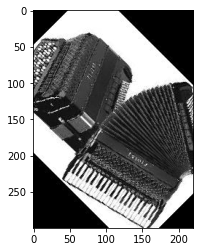

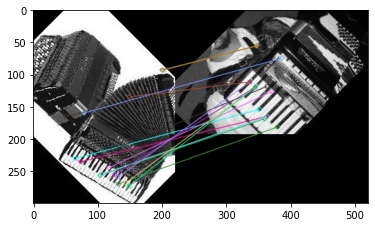

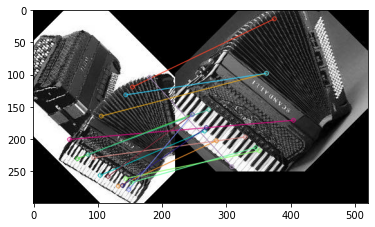

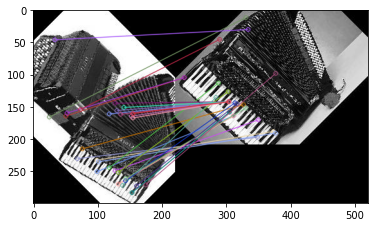

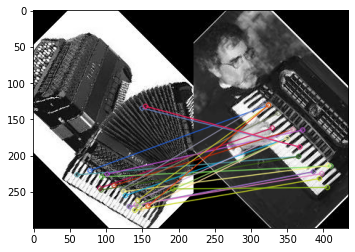

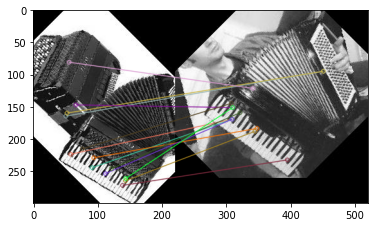

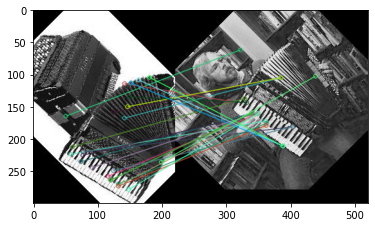

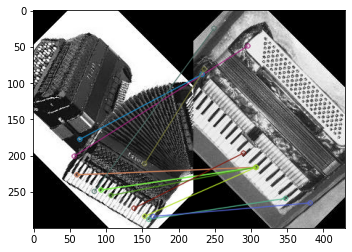

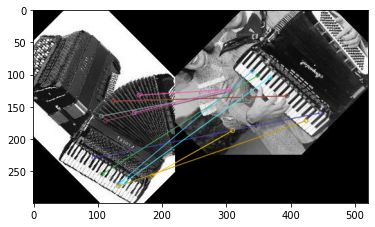

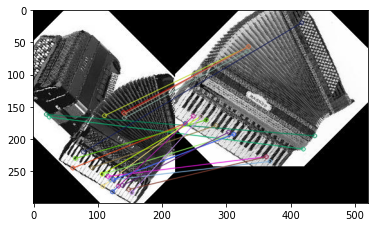

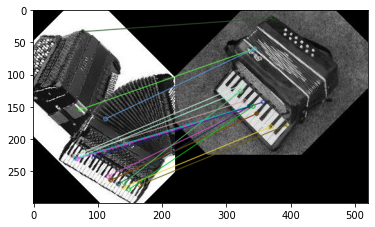

Accuracy: 0.12941176470588237


In [8]:
# TODO: find top 10 similar images for the first image of each category
# output results for the "accordion" category and calculate final accuracy
from collections import Counter

def search_in_index(img_path, top_k = 10):
  final_image_ids = Counter()
  # get image descriptors
  descriptors = load_one(img_path)

  # for each and every kp's descriptor we look it up in the index
  for kp in descriptors:
    closest, _ = index.knnQuery(kp, k=10)
    closest = [keypointid_imagepath[id_] for id_ in closest]
    final_image_ids.update(closest)
  del final_image_ids[img_path]
  return final_image_ids.most_common()[:top_k]

def read_and_resize(filename):
    imgbgr = cv.imread(filename, cv.IMREAD_GRAYSCALE)
    return imgbgr

def draw_matches(img1, img2):
  kp1, des1 = sift.detectAndCompute(img1,None)
  kp2, des2 = sift.detectAndCompute(img2,None) 

  bf = cv.BFMatcher()
  matches = bf.knnMatch(des1,des2,k=2)
  good = []
  for m,n in matches:
      if m.distance < 0.75*n.distance:
          good.append([m])
  # cv.drawMatchesKnn expects list of lists as matches.
  img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
  plt.imshow(img3),plt.show()

def eval_search(data_dir = '101_ObjectCategories', top_k=10, draw = False):
    total_hits = 0
    total_possible_hits = 0
    for cat, true_label in categories.items():
      cat_path = os.path.join(data_dir, cat)
      img_path = os.listdir(cat_path)[0]
      img_path = os.path.join(cat_path, img_path)
      if cat == 'accordion' or draw:
          reference_image = read_and_resize(img_path)
          plt.imshow(reference_image, cmap='gray')
          plt.show()

      relevant_image_paths = search_in_index(img_path, top_k)
      for img_path, _ in relevant_image_paths:
        predicted_label = imgpath_label[img_path]

        if cat == 'accordion' or draw:
          img = read_and_resize(img_path)
          draw_matches(reference_image, img)
          # plt.imshow(img)
          # plt.show()

        if predicted_label == true_label:
          total_hits += 1
    return total_hits/(len(categories)*10)
        
      
accuracy = eval_search()
print(f'Accuracy: {accuracy}')